# Background
---

# Prior and Simulations
---

In [ ]:
from glass_sim import *
import scipy as sp
import pickle
from tqdm.notebook import tqdm

## 1. Prior Parameters: $\bm{\theta}\sim P(\bm{\theta})$

In [3]:
def prior_param_samples(h_range, Oc_range, Ob_range, type, n_samples):
    assert isinstance(h_range, tuple) and len(h_range) == 2, "h_range must be a tuple of (min, max)"
    assert isinstance(Oc_range, tuple) and len(Oc_range) == 2, "Oc_range must be a tuple of (min, max)"
    assert isinstance(Ob_range, tuple) and len(Ob_range) == 2, "Ob_range must be a tuple of (min, max)"
    assert type in ["uniform", "normal"], "type must be either 'uniform' or 'normal'"
    assert isinstance(n_samples, int) and n_samples > 0, "n_samples must be a positive integer"
    if type == "uniform":
        h_samples = np.random.uniform(h_range[0], h_range[1], n_samples)
        Oc_samples = np.random.uniform(Oc_range[0], Oc_range[1], n_samples)
        Ob_samples = np.random.uniform(Ob_range[0], Ob_range[1], n_samples)
        samples = np.vstack((h_samples, Oc_samples, Ob_samples)).T
    elif type == "normal":
        cov = np.diag([h_range[1] - h_range[0], Oc_range[1] - Oc_range[0], Ob_range[1] - Ob_range[0]])**2 / 12
        mean = [(h_range[0] + h_range[1]) / 2, (Oc_range[0] + Oc_range[1]) / 2, (Ob_range[0] + Ob_range[1]) / 2]
        samples = np.random.multivariate_normal(mean, cov, n_samples)
    return samples


h_range = (0.6, 0.8)
Oc_range = (0.2, 0.4)
Ob_range = (0.03, 0.05)
n_samples = 1000
uniform_samples = prior_param_samples(h_range, Oc_range, Ob_range, "uniform", n_samples)
print("Uniform Samples:\n", uniform_samples)
normal_samples = prior_param_samples(h_range, Oc_range, Ob_range, "normal", n_samples)
print("Normal Samples:\n", normal_samples)


Uniform Samples:
 [[0.67127797 0.24631764 0.03930163]
 [0.63820288 0.31063843 0.04049825]
 [0.7641133  0.21059579 0.03818628]
 ...
 [0.73614374 0.27308554 0.04812864]
 [0.7426277  0.28592033 0.03100873]
 [0.74335528 0.28694929 0.03507314]]
Normal Samples:
 [[0.63606232 0.29231362 0.04210464]
 [0.75295432 0.30755543 0.04046834]
 [0.76028847 0.36419311 0.04230839]
 ...
 [0.65538834 0.27502339 0.0475562 ]
 [0.65362443 0.34841274 0.04657254]
 [0.74755079 0.31960693 0.04408072]]


##  2. Simulated Data: $\bm{x}|\bm{\theta}$

In [ ]:
param_samples = []
cls_samples = []

for i in range(uniform_samples.shape[0]):
    cosmology = {}
    cosmology['h'], cosmology['Oc'], cosmology['Ob'] = uniform_samples[i] # unpacking
    # sim = lensing_cls_sim(cosmology, random seed=np.random.randint(0, n_samples*10))
    param_samples.append(sim['params'])
    cls_samples.append(sim['cls'])
param_samples = np.array(param_samples)
cls_samples = np.array(cls_samples) 

# with open('sbi_demo_data.pkl', 'wb') as f:
    # pickle.dump({'params': param_samples, 'cls': cls_samples}, f)

17it [00:00, 31.02it/s]
15it [00:00, 34.17it/s]
18it [00:00, 37.12it/s]
16it [00:00, 35.52it/s]
17it [00:00, 35.56it/s]
15it [00:00, 36.76it/s]
15it [00:00, 34.71it/s]
16it [00:00, 36.13it/s]
15it [00:00, 36.17it/s]
14it [00:00, 36.49it/s]
15it [00:00, 36.37it/s]
14it [00:00, 35.86it/s]
13it [00:00, 34.70it/s]
18it [00:00, 35.15it/s]
19it [00:00, 37.11it/s]
14it [00:00, 35.47it/s]
16it [00:00, 34.62it/s]
17it [00:00, 36.69it/s]
14it [00:00, 36.51it/s]
15it [00:00, 37.29it/s]
14it [00:00, 35.37it/s]
14it [00:00, 36.18it/s]
17it [00:00, 36.27it/s]
18it [00:00, 34.80it/s]
17it [00:00, 34.82it/s]
16it [00:00, 36.90it/s]
17it [00:00, 37.30it/s]
18it [00:00, 35.74it/s]
14it [00:00, 36.09it/s]
14it [00:00, 33.44it/s]
14it [00:00, 37.80it/s]
17it [00:00, 37.35it/s]
14it [00:00, 36.80it/s]
17it [00:00, 35.88it/s]
14it [00:00, 35.29it/s]
15it [00:00, 35.95it/s]
17it [00:00, 34.88it/s]
15it [00:00, 35.56it/s]
17it [00:00, 37.16it/s]
17it [00:00, 36.70it/s]
15it [00:00, 36.99it/s]
16it [00:00, 35.

[[0.61472658 0.39276254 0.03335395]
 [0.78487477 0.20699569 0.04902409]
 [0.61452539 0.31156078 0.04228655]
 ...
 [0.67568812 0.34656609 0.04528984]
 [0.69783261 0.30375066 0.04894499]
 [0.62556569 0.23469396 0.04522031]]
[[1.13918457e-09 1.59512792e-08 5.06079500e-08 ... 1.36070607e-09
  1.25186004e-09 1.42119535e-09]
 [1.70528808e-10 1.33758420e-08 3.30221996e-08 ... 3.94849466e-10
  3.59168858e-10 3.90911533e-10]
 [5.37669088e-10 1.38230047e-08 4.31993431e-08 ... 6.75661852e-10
  6.28077520e-10 7.10073215e-10]
 ...
 [8.49301187e-10 1.64105173e-08 4.75726437e-08 ... 1.20800157e-09
  1.09947196e-09 1.22787685e-09]
 [5.63246218e-10 1.55992898e-08 4.37180555e-08 ... 8.99398125e-10
  8.19294323e-10 9.08845984e-10]
 [2.44435967e-10 1.11586880e-08 3.49771137e-08 ... 2.86283691e-10
  2.68441691e-10 3.01715220e-10]]


# Dimensionality reduction
---

## Linear compression
Let $\{\mathbf{x}_1,...,\mathbf{x}_N\}$ be the set of simulated data with corresponding.  
$$
\tilde{\mathbf{x}}_{(r\times1)} = T_{(r\times d)}\:\mathbf{x}_{(d\times1)}
$$
$T$ can be obtained via:

1. Canoncical correlation analysis
    - Maximises the correlation between the parameters and data (also could be written as maximising the mutual information).
    - Use canonical data vectors as compressed data
1. MOPED
    - Heavens, Alan F., Raul Jimenez, and Ofer Lahav. "Massive lossless data compression and multiple parameter estimation from galaxy spectra." (2000)
    - Assumes Gaussian likelihood surface and preserves the Fisher Information, as a result:
        - requires fiducial cosmology simulations for covariance estimation
        - requires additional simulation cost for mean derivative estimation
1. e-MOPED 
    - Park, M., Gatti, M., & Jain, B. (2025). Dimensionality reduction techniques for statistical inference in cosmology.
    - Define new data space as a transform of the parameter space centred at the mean parameter.


### 1. Canonical correlation analysis (CCA) compression

In [64]:
def cca(param_samples, cls_samples):
    '''
    Compute the sampled parameter auto covariance, simulated data vector auto covariance and the parameter-data vector cross covariance
    Methodology as per Park, M., Gatti, M., & Jain, B. (2025). Dimensionality reduction techniques for statistical inference in cosmology.
        - output has the shape of n_samples x n_params
    '''
    cov = np.cov(param_samples.T, cls_samples.T)
    param_count = param_samples.shape[1]
    cp = cov[:param_count,:param_count]
    ct = cov[param_count:,param_count:]
    ctp = cov[param_count:,:param_count]
    # print('Cp',cp.shape,'Ct',ct.shape,'Ctp',ctp.shape)

    cl = ctp@np.linalg.inv(cp).T@ctp.T
    # print('Cl',cl.shape,np.linalg.matrix_rank(cl))


    # print((np.linalg.inv(ct)@cl).shape)
    # print(np.linalg.matrix_rank(np.linalg.inv(ct)@cl))

    # Using scipy's eigh function for generalized eigenvalue problem, requires symmetric matrices and positive definite ct-cl
    e_vals, e_vecs = sp.linalg.eigh(ct, ct - cl)
    print('e_vals',e_vals.shape,'e_vecs',e_vecs.shape)
    canon_corr = e_vals[::-1][:param_count]
    canon_projs = e_vecs[:,::-1][:,:param_count]
    
    # Using numpy's eig function for generalized eigenvalue problem, less efficient but works for non-symmetric matrices)
    # e_vals, e_vecs = np.linalg.eig(np.linalg.inv(ct)@cl)
    # print('e_vals',e_vals.shape,'canon_projs',canon_projs.shape)

    print(e_vals)
    plt.plot(np.arange(0,param_count),e_vals[:(-1*param_count-1):-1])
    plt.title('Canonical correlations')
    plt.xlabel('Component number')
    plt.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.ylabel('Correlation')
    plt.show()
    
    return {'params': param_samples, 'compressed_cls': cls_samples@canon_projs}

e_vals (257,) e_vecs (257, 257)
[9.68018476e-01 9.75087001e-01 9.77523844e-01 9.81989011e-01
 9.82557566e-01 9.83838295e-01 9.85100259e-01 9.85652921e-01
 9.88003776e-01 9.88459838e-01 9.89707166e-01 9.90396906e-01
 9.91196529e-01 9.92101217e-01 9.92263493e-01 9.92715578e-01
 9.93606852e-01 9.94085647e-01 9.94538036e-01 9.94878646e-01
 9.95019957e-01 9.95515694e-01 9.95951476e-01 9.96071824e-01
 9.96442644e-01 9.96647977e-01 9.97011148e-01 9.97492054e-01
 9.97719275e-01 9.97841819e-01 9.97891812e-01 9.97958381e-01
 9.98159111e-01 9.98328259e-01 9.98411241e-01 9.98486042e-01
 9.98602617e-01 9.98715051e-01 9.98833161e-01 9.98872891e-01
 9.98947553e-01 9.99051803e-01 9.99157646e-01 9.99306278e-01
 9.99345136e-01 9.99386576e-01 9.99455574e-01 9.99462751e-01
 9.99521184e-01 9.99551629e-01 9.99557914e-01 9.99588707e-01
 9.99631670e-01 9.99654940e-01 9.99705308e-01 9.99718706e-01
 9.99726922e-01 9.99758697e-01 9.99789962e-01 9.99811269e-01
 9.99835584e-01 9.99855840e-01 9.99863569e-01 9.99879

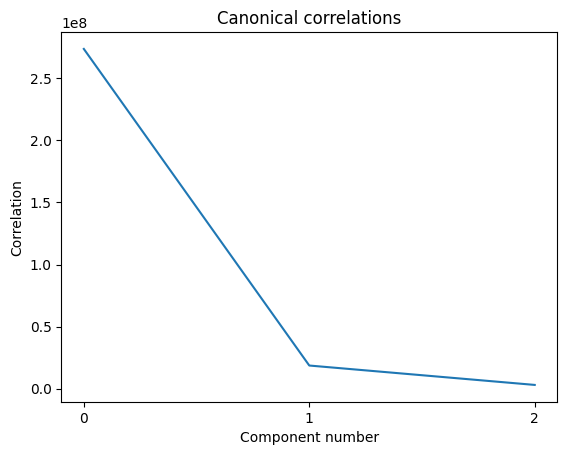

compressed dataset has shape of (1000, 3)
compressed dataset [[-105711.08069289   -6022.32630473   -5104.1140038 ]
 [ -61891.66052063   10195.57220103   -9635.27400993]
 [ -84052.26904895   -4328.42898795   -7940.18546479]
 ...
 [ -96854.70112756     437.79542144   -8590.91439918]
 [ -86109.62360304    2888.40651501   -9699.88113565]
 [ -63068.21491238   -2568.47816824   -8927.92609675]]


In [66]:
with open('sbi_demo_data.pkl', 'rb') as f:
    load = pickle.load(f)
    param_samples = load['params']
    cls_samples = load['cls']

cca_result = cca(param_samples, cls_samples)
print('compressed dataset has shape of',cca_result['compressed_cls'].shape)
print('compressed dataset', cca_result['compressed_cls'])

with open('cca_compressed_data.pkl', 'wb') as f:
    pickle.dump(cca_result, f)

### 2. Massive lossless data compression (MOPED)

In [24]:
def moped(param_samples, cls_samples, fiducial_cls_samples, perturbed_cls_samples, deltas, n_fiducial_samples, n_perturbed_samples):
    '''
    fiducial_cls used for covariance computation
    perturbed_cls used for mean derivative computation
        - output has the shape of n_samples x n_params
    '''
    assert n_fiducial_samples >= n_perturbed_samples, "Number of fiducial samples must be greater than or equal to number of perturbed samples"

    cov_matrix = np.cov(fiducial_cls_samples.T)

    fiducial_cls_array = fiducial_cls_samples[:n_perturbed_samples,:]
    deriv = []
    for i, (direction, sims) in enumerate(perturbed_cls_samples.items()):
        perturbed_cls = sims['cls'][:n_perturbed_samples,:]
        deriv.append(np.mean(perturbed_cls - fiducial_cls_array, axis=0)/deltas[i]) #first order finite difference
        print('order of compression:', i+1, direction)
    deriv = np.array(deriv) # shape d_params x d_cls
    compression_matrix = np.zeros((param_samples.shape[1], cls_samples.shape[1])) # initialize compression matrix d_params x d_cls

    for i in range(param_samples.shape[1]):
        invcov_deriv = np.linalg.solve(cov_matrix, deriv[i])
        if i>0:
            coefs = compression_matrix[:i,:]@deriv[i]
            compression_matrix[i,:]= (invcov_deriv - compression_matrix[:i,:].T@coefs)/np.sqrt(deriv[i]@invcov_deriv- np.sum(coefs**2))
        else:
            compression_matrix[i,:]= (invcov_deriv)/np.sqrt(deriv[i]@invcov_deriv)

    compressed_cls = compression_matrix@cls_samples.T
    
    return {'params': param_samples, 'compressed_cls': compressed_cls.T}



In [8]:
# Generate fiducial data for MOPED compression

fiducial_params = {'h': 0.7, 'Oc': 0.3, 'Ob': 0.04}
n_fiducial_samples = 300

fiducial_param_samples = []
fiducial_cls_samples = []
for n in tqdm(range(n_fiducial_samples)):
    # sim = lensing_cls_sim(fiducial_params, random_seed=np.random.randint(0,n_fiducial_samples*10))
    fiducial_param_samples.append(sim['params'])
    fiducial_cls_samples.append(sim['cls'])
fiducial_param_samples = np.array(fiducial_param_samples)
fiducial_cls_samples = np.array(fiducial_cls_samples)

# print("Fiducial Params:\n", fiducial_param_samples)
# print("Fiducial Cls:\n", fiducial_cls_samples)

# with open('moped_fiducial_cls.pkl', 'wb') as f:
#     pickle.dump({'params': fiducial_param_samples, 'cls': fiducial_cls_samples}, f)

100%|██████████| 300/300 [20:54<00:00,  4.18s/it]


In [21]:
# Generate perturbed data for MOPED compression, use predefiined fiducial parameters 

fiducial_params = {'h': 0.7, 'Oc': 0.3, 'Ob': 0.04}
delta_params = {'h': 0.01, 'Oc': 0.01, 'Ob': 0.001}
perturbations = {
    'dh': {'h': fiducial_params['h']+delta_params['h'], 'Oc': fiducial_params['Oc'], 'Ob': fiducial_params['Ob']},
    'dOc': {'h': fiducial_params['h'], 'Oc': fiducial_params['Oc']+delta_params['Oc'], 'Ob': fiducial_params['Ob']},
    'dOb': {'h': fiducial_params['h'], 'Oc': fiducial_params['Oc'], 'Ob': fiducial_params['Ob']+delta_params['Ob']}
}

perturb_cls = {}
n_perturb_samples = 50

for direction, perturb_params in perturbations.items():
    perturb_param_samples = []
    perturb_cls_samples = []
    for n in tqdm(range(n_perturb_samples)):
        # sim = lensing_cls_sim(perturb_params, random_seed=np.random.randint(0,n_perturb_samples*10))
        perturb_param_samples.append(sim['params'])
        perturb_cls_samples.append(sim['cls'])
    # print("Fiducial Params:\n", fiducial_param_samples)
    # print("Fiducial Cls:\n", fiducial_cls_samples)
    temp_dict = {'params':np.array(perturb_param_samples), 'cls':np.array(perturb_cls_samples)}
    perturb_cls[direction] = temp_dict

# with open(f'moped_perturbed_cls.pkl', 'wb') as f:
#     pickle.dump(perturb_cls, f)

100%|██████████| 50/50 [00:00<00:00, 1388842.38it/s]


In [ ]:
with open('sbi_demo_data.pkl', 'rb') as f:
    load = pickle.load(f)
    param_samples = load['params']
    cls_samples = load['cls']

with open('moped_fiducial_cls.pkl', 'rb') as f:
    load = pickle.load(f)
    fiducial_cls_samples = load['cls']

with open('moped_perturbed_cls.pkl', 'rb') as f:
    load = pickle.load(f)
    perturb_cls = load

moped_result = moped(param_samples, cls_samples, fiducial_cls_samples, perturb_cls, [0.01, 0.01, 0.005], 300, 50)
print('MOPED compressed dataset has shape of',moped_result['compressed_cls'].shape)
# print(moped_result['compressed_cls'])
# print(moped_result)

# with open('moped_compressed_data.pkl', 'wb') as f:
#     pickle.dump(moped_result, f)

order of compression: 1 dh
order of compression: 2 dOc
order of compression: 3 dOb
MOPED compressed dataset has shape of (1000, 3)


In [ ]:
def emoped(param_samples, cls_samples, fiducial_cls, perturbed_cls):
    '''
    fiducial_cls used for covariance computation
    perturbed_cls used for mean derivative computation
    '''
    return {'params': param_samples, 'compressed_cls': compressed_cls}

# Density Estimation
---